[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://drive.google.com/file/d/1kYjGK-X8u_C0vR7T5M1xyMYVgLVjDYc1/view?usp=sharing)

In [1]:
import tensorflow as tf
from collections import Counter
from sklearn.model_selection import train_test_split
import pickle
import os
import re
import itertools
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import f1_score
from numpy import ndarray


%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
# Add dataset path
path = "./data/"
folder = "raw/"
filename = "Rest_Mex_Sentiment_Analysis_2023_Train.xlsx"
# reading the data
df = pd.read_excel(path + folder + filename)
df = df.fillna("")

In [3]:
def to_weights(x):
    return 1.0 / x


df["Polarity"] = df["Polarity"] - 1
X, y = df["Review"], df["Polarity"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

datasets = pd.DataFrame({"X_train": X_train, "y_train": y_train})

test = pd.DataFrame({"X_test": X_test, "y_test": y_test})

print(f"Stratified sampling mode : ")
datasets["freq"] = datasets.groupby("y_train")["y_train"].transform("count")
test["freq"] = test.groupby("y_test")["y_test"].transform("count")
datasets_balanced = datasets.sample(
    n=len(datasets), replace=True, weights=datasets["freq"].apply(to_weights)
).copy()
test_balanced = test.sample(
    n=len(test), replace=True, weights=test["freq"].apply(to_weights)
).copy()

Stratified sampling mode : 


In [4]:
print(f"The values of the first 5 rows are : ")
datasets_balanced.head()

The values of the first 5 rows are : 


,X_train,y_train,freq
31550,Las otras dos ocasiones estábamos en la Habana...,1,4683
119911,Magnífico hotel excelentemente situado en la b...,4,105115
72680,No vale la pena el dinero a allí.Las ruinas so...,0,3849
222643,Un museo bastante característico de esta ciuda...,1,4683
132951,"Excelente sabor, calidad en los.platillos y el...",4,105115


### Sentiment Analysis (Polarity)

In [5]:
def preprocess(X_batch, min_length=0, max_length=308, tensor_mode=True):
    X_batch = str(X_batch).lower()
    X_batch = re.sub(r"[á']", r"a", X_batch)
    X_batch = re.sub(r"[é']", r"e", X_batch)
    X_batch = re.sub(r"[í']", r"i", X_batch)
    X_batch = re.sub(r"[ó']", r"o", X_batch)
    X_batch = re.sub(r"[ú']", r"u", X_batch)
    # X_batch = ''.join(i for i, _ in itertools.groupby(X_batch))
    X_batch = re.sub(r"(.)\1+", r"\1", X_batch)
    X_batch = tf.strings.substr(X_batch, min_length, max_length)
    X_batch = tf.strings.regex_replace(X_batch, r"[^a-zA-Zñ']", r" ")
    X_batch = tf.strings.regex_replace(X_batch, r"[^\w\s]", r"")
    X_batch = tf.strings.split(X_batch)
    X_batch = [str(w).replace("b'", "").replace("'", "") for w in X_batch.numpy()]
    n = len(X_batch)
    X_add = [""] * (max_length - n)
    X_batch += X_add
    if tensor_mode:
        return tf.convert_to_tensor(X_batch)
    else:
        return X_batch

In [6]:
if os.path.exists("vocab.pkl"):
    with open("vocab.pkl", "rb") as file:
        vocabulary = pickle.load(file)
else:
    vocabulary = Counter()
    reviews = df[["Review"]].iloc[:, 0].apply(preprocess, tensor_mode=False)
    for X_batch in reviews:
        vocabulary.update(X_batch)

    with open("vocab.pkl", "wb") as file:
        pickle.dump(vocabulary, file)

In [7]:
# top 5 most common words
vocabulary.most_common()[:5]

[('', 67319267), ('de', 481028), ('la', 409793), ('y', 386605), ('el', 309147)]

In [8]:
print(f"Total size of the vocabulary : ", "{:,}".format(len(vocabulary.most_common())))
print("-------------------------------------------------------")

Total size of the vocabulary :  94,814
-------------------------------------------------------


In [9]:
# let's truncate the vocabulary, keeping only the 10,000 most common words
vocab_size = 10000
truncated_vocabulary = [word for word, count in vocabulary.most_common()[:vocab_size]]

# now we add a preprocessing step to replace each work with its ID
words = tf.constant(truncated_vocabulary)
words_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, words_ids)
# we will create a lookup table for this, using 1,000 out-of-vocabulary (oov) buckets
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

In [10]:
print(f"1) Example of use.")
print("-------------------------------------------------------")
text = "Muy buena la atención de principio a fin en el restaurante Serratta. Por parte de Jonathan. Recomendado."
# print('preprocess text : ', preprocess(text))
# table.lookup(preprocess(text)).numpy()

1) Example of use.
-------------------------------------------------------


In [11]:
depth = 5


# now we create the encode_words() function that uses the table we just built
def encode_words(X_batch):
    if X_batch.isnumeric():
        X_batch = ""
    return list(table[preprocess(X_batch)].numpy())


datasets_balanced = datasets_balanced.drop(columns=["freq"])
test_balanced = test_balanced.drop(columns=["freq"])
training_sentences = datasets_balanced["X_train"].to_list()
testing_sentences = test_balanced["X_test"].to_list()

embed_size = 16
max_length = 32
trunc_type = "post"
padding_type = "post"
oov_tok = ""

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(training_sentences)

padded = tf.keras.preprocessing.sequence.pad_sequences(
    sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type
)
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = tf.keras.preprocessing.sequence.pad_sequences(
    testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type
)
padded.shape

(168640, 32)

In [12]:
if os.path.exists("train_x.pkl"):
    with open("train_x.pkl", "rb") as file:
        train_x = pickle.load(file)

    with open("test_x.pkl", "rb") as file:
        test_x = pickle.load(file)
else:
    train_x = np.array(
        [encode_words(sentence) for sentence in datasets_balanced["X_train"].to_list()]
    )
    test_x = np.array([encode_words(sentence) for sentence in test_balanced["X_test"].to_list()])

    with open("train_x.pkl", "wb") as file:
        pickle.dump(train_x, file)

    with open("test_x.pkl", "wb") as file:
        pickle.dump(test_x, file)

In [13]:
if os.path.exists("hub_train_x.pkl"):
    with open("hub_train_x.pkl", "rb") as file:
        hub_train_x = pickle.load(file)

    with open("hub_test_x.pkl", "rb") as file:
        hub_test_x = pickle.load(file)
else:
    hub_train_x = np.array([sentence for sentence in datasets_balanced["X_train"].to_list()])
    hub_test_x = np.array([sentence for sentence in test_balanced["X_test"].to_list()])

    try:
        with open("hub_train_x.pkl", "wb") as file:
            pickle.dump(hub_train_x, file)

        with open("hub_test_x.pkl", "wb") as file:
            pickle.dump(hub_test_x, file)
    except MemoryError:
        print("It is not possible to save the dataset")

In [14]:
train_y = datasets_balanced["y_train"]
train_y = (tf.one_hot(train_y, depth)).numpy()

test_y = test_balanced["y_test"]
test_y = (tf.one_hot(test_y, depth)).numpy()

train_x.shape

(168640, 308)

In [15]:
train_y.shape

(168640, 5)

### Reusing Pretrained Embeddings

Epoch 1/35
5270/5270 [==============================] - 45s 8ms/step - loss: 0.5031 - accuracy: 0.2817 - val_loss: 0.4814 - val_accuracy: 0.3367
Epoch 2/35
5270/5270 [==============================] - 25s 5ms/step - loss: 0.4675 - accuracy: 0.3632 - val_loss: 0.4582 - val_accuracy: 0.3699
Epoch 3/35
5270/5270 [==============================] - 24s 5ms/step - loss: 0.4501 - accuracy: 0.3853 - val_loss: 0.4462 - val_accuracy: 0.3868
Epoch 4/35
5270/5270 [==============================] - 25s 5ms/step - loss: 0.4402 - accuracy: 0.4000 - val_loss: 0.4390 - val_accuracy: 0.3990
Epoch 5/35
5270/5270 [==============================] - 25s 5ms/step - loss: 0.4341 - accuracy: 0.4091 - val_loss: 0.4348 - val_accuracy: 0.4057
Epoch 6/35
5270/5270 [==============================] - 25s 5ms/step - loss: 0.4304 - accuracy: 0.4142 - val_loss: 0.4322 - val_accuracy: 0.4098
Epoch 7/35
5270/5270 [==============================] - 24s 5ms/step - loss: 0.4279 - accuracy: 0.4169 - val_loss: 0.4303 - val_ac

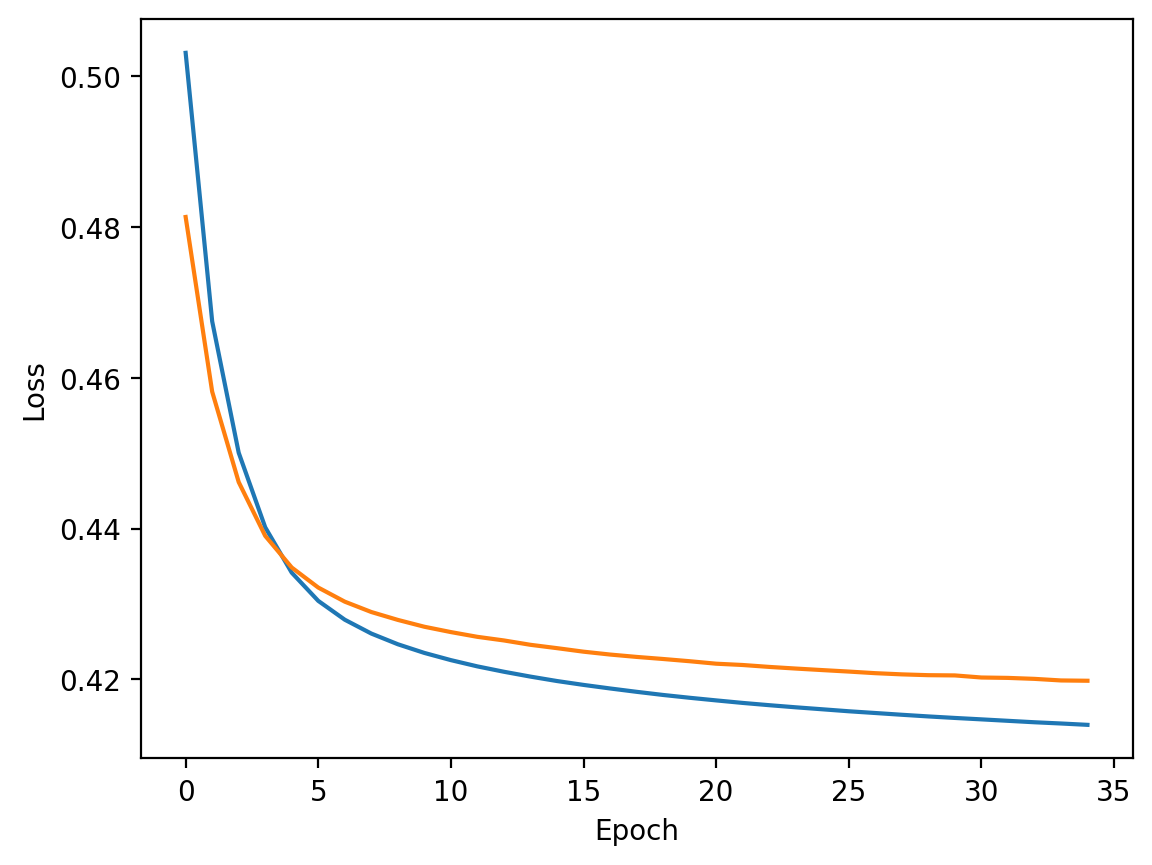

c:\Users\think-opti\Documents\envs\ban\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
# TF Hub repository (https://tfhub.dev)

import tensorflow_hub as hub

model = tf.keras.Sequential(
    [
        hub.KerasLayer(
            "https://tfhub.dev/google/tf2-preview/nnlm-es-dim50/1",
            output_shape=[50],
            input_shape=[],
            dtype=tf.string,
        ),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(5, activation="sigmoid"),
    ]
)

model.compile(loss="binary_crossentropy", optimizer="sgd", metrics=["accuracy"])

history = model.fit(hub_train_x, train_y, epochs=35, validation_data=(hub_test_x, test_y))


def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist["epoch"] = history.epoch
    hist.tail()

    # plot history
    plt.plot(history.history["loss"], label="Train Error")
    plt.plot(history.history["val_loss"], label="Validation Error")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()


plot_history(history)
model.save("saved_model/hub_model.h5")

Epoch 1/5
5270/5270 [==============================] - 369s 69ms/step - loss: 0.5069 - accuracy: 0.2158 - val_loss: 0.4999 - val_accuracy: 0.2105
Epoch 2/5
5270/5270 [==============================] - 361s 69ms/step - loss: 0.4994 - accuracy: 0.2322 - val_loss: 0.4987 - val_accuracy: 0.2415
Epoch 3/5
5270/5270 [==============================] - 387s 73ms/step - loss: 0.4972 - accuracy: 0.2432 - val_loss: 0.4957 - val_accuracy: 0.2417
Epoch 4/5
5270/5270 [==============================] - 371s 70ms/step - loss: 0.4947 - accuracy: 0.2441 - val_loss: 0.4945 - val_accuracy: 0.2426
Epoch 5/5
5270/5270 [==============================] - 375s 71ms/step - loss: 0.4941 - accuracy: 0.2435 - val_loss: 0.4941 - val_accuracy: 0.2424


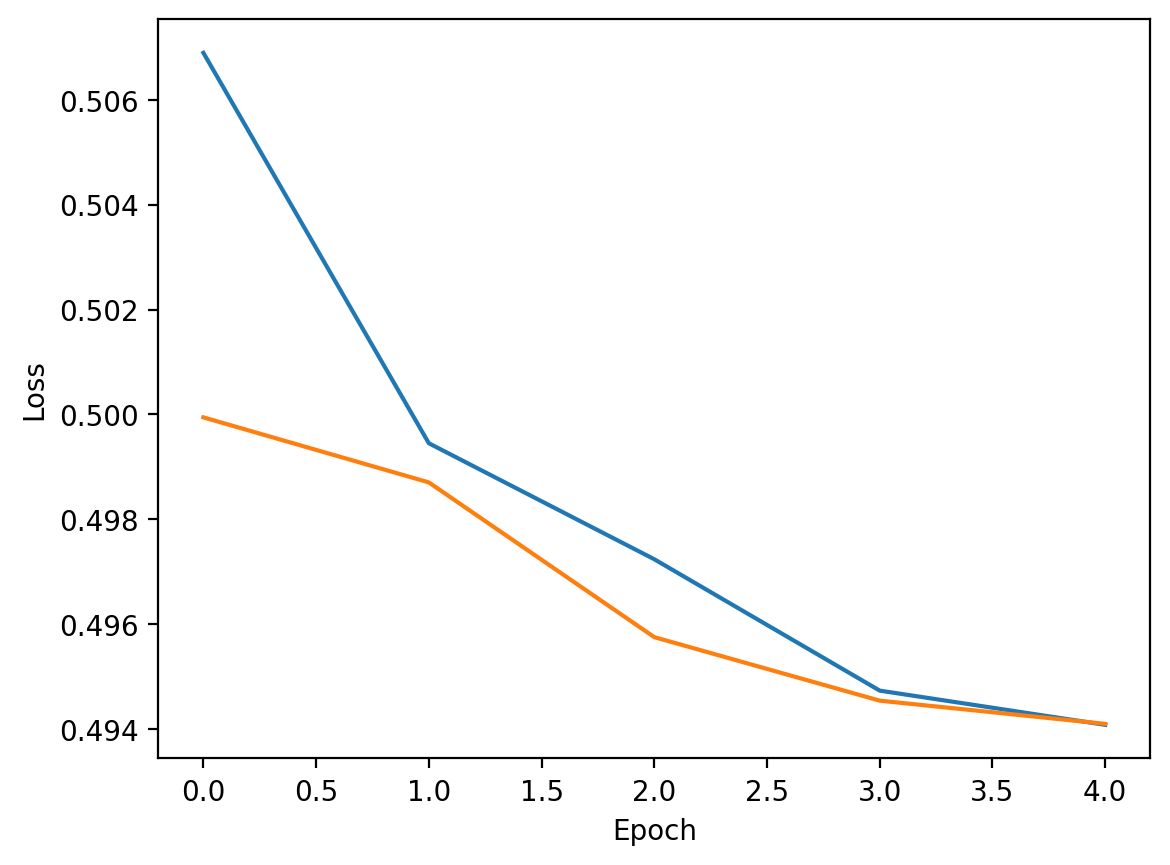

c:\Users\think-opti\Documents\envs\ban\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
# at last we create the model and train it

custom_model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Embedding(
            vocab_size, embed_size, input_shape=[None], input_length=max_length
        ),
        tf.keras.layers.GRU(128, return_sequences=True),
        tf.keras.layers.GRU(128),
        tf.keras.layers.Dense(5, activation="sigmoid"),
    ]
)

custom_model.compile(loss="binary_crossentropy", optimizer="sgd", metrics=["accuracy"])

history = custom_model.fit(padded, train_y, epochs=5, validation_data=(testing_padded, test_y))

plot_history(history)
custom_model.save("saved_model/custom_model.h5")

In [18]:
class PerformanceMeasures:
    """Class with methods to measure performance"""

    def __init__(self) -> None:
        pass

    # Performance measure Res_T
    def f_mean(self, y_true: ndarray, y_pred: ndarray, labels: list) -> None:
        n = len(labels)

        F_vec = f1_score(y_true, y_pred, average=None, labels=labels)
        a = np.sum(F_vec)

        for i in range(len(F_vec)):
            print("F-measure of label ", labels[i], " -> ", F_vec[i])

        print("Mean of F-measure -> ", a / n)

    # Performance measure Res_P
    def resp(self, y_true: ndarray, y_pred: ndarray, labels: list) -> None:
        # We initialize sum counters
        sum1 = 0
        sum2 = 0

        # Calculamos T_C
        T_C = len(y_true)
        for i in range(len(labels)):
            # We calculate instances of the classes and their F-measures
            sum1 += (1 - ((y_true == labels[i]).sum() / T_C)) * self._fi_measure(
                y_true, y_pred, labels, i
            )
            sum2 += 1 - ((y_true == labels[i]).sum()) / T_C

        # Print the metric corresponding to the prediction vector
        print("Metric Res_p ->", sum1 / sum2)

    def _fi_measure(self, y_true: ndarray, y_pred: ndarray, labels: list, i: int) -> int:
        F_vec = f1_score(y_true, y_pred, average=None, labels=labels)

        return F_vec[i]  # We return the position of the f1-score corresponding to the label

### Performance of the model tfhub

In [19]:
labels = [0, 1, 2, 3, 4]
prediction = model.predict(hub_test_x)
prediction = tf.argmax(prediction, axis=1).numpy()
ground_true = tf.argmax(test_y, 1).numpy()

metrics = PerformanceMeasures()
metrics.f_mean(ground_true, prediction, labels)
metrics.resp(ground_true, prediction, labels)

2596/2596 [==============================] - 10s 4ms/step
F-measure of label  0  ->  0.5268228954029559
F-measure of label  1  ->  0.3175707000463607
F-measure of label  2  ->  0.3099032163456838
F-measure of label  3  ->  0.3470960032703374
F-measure of label  4  ->  0.5622257950241164
Mean of F-measure ->  0.4127237220178908
Metric Res_p -> 0.41270147893241077


### Performance of the custom model

In [20]:
prediction = custom_model.predict(testing_padded)
prediction = tf.argmax(prediction, axis=1).numpy()

metrics.f_mean(ground_true, prediction, labels)
metrics.resp(ground_true, prediction, labels)

2596/2596 [==============================] - 46s 18ms/step
F-measure of label  0  ->  0.0
F-measure of label  1  ->  0.3571471046465992
F-measure of label  2  ->  0.0180241455534773
F-measure of label  3  ->  0.0
F-measure of label  4  ->  0.3154413635207326
Mean of F-measure ->  0.1381225227441618
Metric Res_p -> 0.13809414980145188
